In [1]:
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting 
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting                     

# Machine Learning Packages (scikit-learn):
from sklearn.svm import SVR                           # Support Vector Machine
from sklearn.svm import LinearSVR

from sklearn.ensemble import RandomForestRegressor    # Random Forest
from sklearn.linear_model import LinearRegression     # Linear Regression 
from sklearn.linear_model import Ridge                # Linear Regression (with Regularisation)
from sklearn.preprocessing import PolynomialFeatures  # for Linear Regression with Polynoms
from sklearn.tree import DecisionTreeRegressor        # Decission Tree Regressor
from sklearn.gaussian_process import GaussianProcessRegressor  # Gaussian Process !
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,WhiteKernel,
                                              ConstantKernel)
    
from sklearn.neural_network import MLPRegressor       # Neural Net
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeavePGroupsOut
# Cross validations 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
# Scores
from sklearn.metrics import mean_absolute_error as mae # Metric 
from sklearn.metrics import r2_score  as r2                 # Metric
from sklearn.metrics import mean_squared_error as mse  

# Optimisation 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor # G Boosting 


# Keras Model 
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 

# Other Visual etc 
import seaborn as sns
from matplotlib.patches import Patch  # Thi is a function to generate plot 
from matplotlib import cm
np.random.seed(1338)

Using TensorFlow backend.


In [2]:
df1= pd.read_csv("Data.csv", index_col='Datetime', parse_dates=True) 
df2= pd.read_csv("Data2020.csv", index_col='Datetime', parse_dates=True)
df = pd.concat([df1,df2 ])

In [3]:
features=df
features.insert(1,"SMeanT",df.MeanT-df.SetTemp)  # Insert Output
features.SMeanT=features.SMeanT.shift(-1)       # Shift output by 1 place !

In [4]:

windows=['Win_AFT', 'Win_AFB','Win_ARoof', 'Win_Akip', 'Win_BFT', 'Win_BFB', 'Win_Broof', 'Win_BKip','Vfloor_A','Vfloor_B']
features = features[ [ col for col in features.columns if col not in windows ] + windows ]
Names=list(features.columns)
unwanted = { 'group', 'WindD','SMeanT', 'WindDc','hourC','hourS','Rain','SetTemp','Spa','MeanC','WindDC_nan','WindDs'}
Xnames = [e for e in Names if e not in unwanted]
features['group'] = (features.index -features.index[0]).days


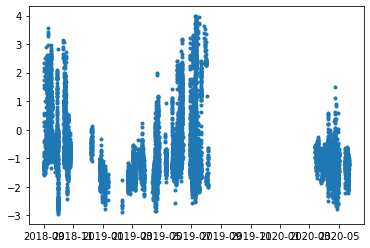

In [5]:
# Filter SMEANT 
features=features.loc[features.SMeanT.between(-3,4),:]
plt.plot(features.SMeanT,'.')

In [6]:
features=features.dropna(axis=0)

In [7]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 40).split(features, groups=features['group']))

Train = features.iloc[train_inds]
Test = features.iloc[test_inds]

X = Train[Xnames].values
y = Train["SMeanT"].values  
print("X.shape:  ", X.shape)
print("y.shape:  ", y.shape)

X_test = Test[Xnames].values
y_test = Test["SMeanT"].values  
print("X.shape:  ", X_test.shape)
print("y.shape:  ", y_test.shape)

X.shape:   (9830, 19)
y.shape:   (9830,)
X.shape:   (3987, 19)
y.shape:   (3987,)


In [8]:
group=Train.group
n_splits=5
cv=GroupShuffleSplit(n_splits,random_state=24) 
ng=len(np.unique(features["group"].values))

# Gausian Process Use different kernel check on test

0.6034218804734482


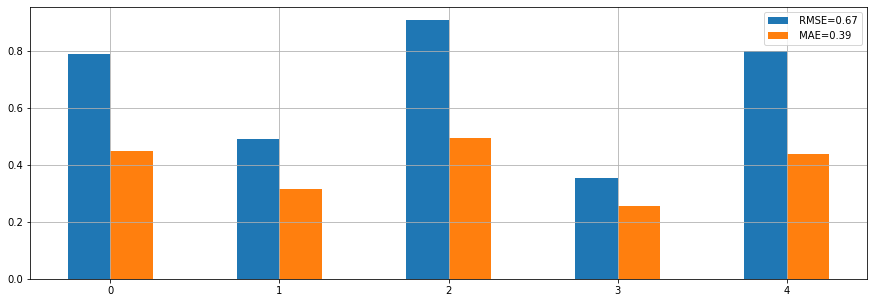

In [9]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) *Matern()                          
GP1 = make_pipeline(StandardScaler(),GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0,normalize_y=True))
GP1.fit(X, y)  


######################################################

scoring = {'mse':"neg_mean_squared_error", 'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}

scor= cross_validate(GP1, X, y, group, cv =cv,scoring=scoring)

mse1 = -scor['test_mse']
mae1 = -scor['test_mae']
r21=  -scor['test_r2']

labels = ['0','1', '2', '3', '4']
mse1 = np.sqrt(-scor['test_mse'])
mae1 = -scor['test_mae']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, mse1, width, label=" RMSE=%.2f"%(np.mean(mse1)),)
rects2 = ax.bar(x + width/2, mae1, width, label=" MAE=%.2f"%(np.mean(mae1)),)
plt.legend()
plt.grid()
print(np.mean(scor['test_r2']))

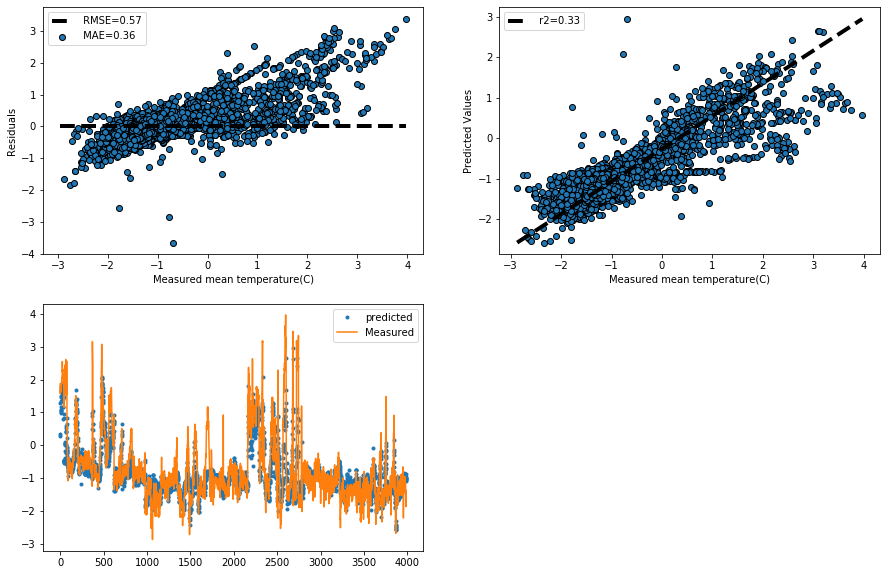

In [11]:
  
Y_pt=GP1.predict(X_test)

mse1 = mse(Y_pt,y_test)
mae1 = mae(Y_pt,y_test)
r21=  r2(Y_pt,y_test)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(y_test,y_test-Y_pt, edgecolors=(0, 0, 0), label=" MAE=%.2f"%(mae1),)
plt.plot([y.min(),y.max()], [0,0], 'k--', lw=4, label=" RMSE=%.2f"%(np.sqrt(mse1)),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Residuals')
plt.legend()


plt.subplot(2,2,2)
plt.scatter(y_test,Y_pt, edgecolors=(0, 0, 0))
plt.plot([y_test.min(),y_test.max()], [Y_pt.min(),Y_pt.max()], 'k--', lw=4,label=" r2=%.2f"%(r21),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Predicted Values')
plt.legend()


ax=plt.subplot(2,2,3)
plt.plot(Y_pt,'.',label="predicted",)
plt.plot(y_test,label="Measured")
plt.legend()



# GP Quard


0.8766814594167751


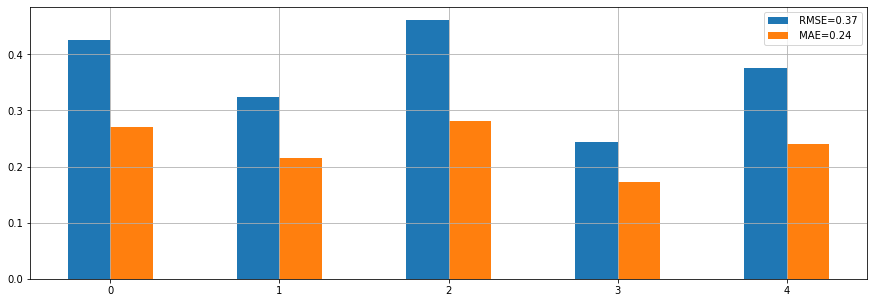

In [12]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RationalQuadratic()
                                
scoring = {'mse':"neg_mean_squared_error", 'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}
GP = make_pipeline(StandardScaler(),GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0,normalize_y=True))
GP.fit(X, y)  
   

######################################################
scoring = {'mse':"neg_mean_squared_error", 'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}

scor= cross_validate(GP, X, y, group, cv =cv,scoring=scoring)

mse1 = -scor['test_mse']
mae1 = -scor['test_mae']
r21=  -scor['test_r2']

labels = ['0','1', '2', '3', '4']
mse1 = np.sqrt(-scor['test_mse'])
mae1 = -scor['test_mae']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, mse1, width, label=" RMSE=%.2f"%(np.mean(mse1)),)
rects2 = ax.bar(x + width/2, mae1, width, label=" MAE=%.2f"%(np.mean(mae1)),)
plt.legend()
plt.grid()
print(np.mean(scor['test_r2']))

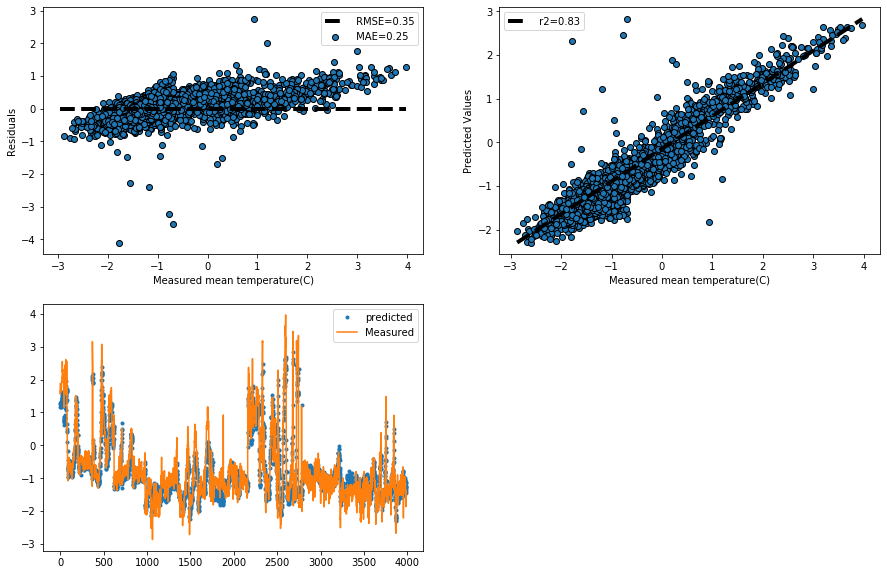

In [13]:
Y_pt=GP.predict(X_test)

mse1 = mse(Y_pt,y_test)
mae1 = mae(Y_pt,y_test)
r21=  r2(Y_pt,y_test)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(y_test,y_test-Y_pt, edgecolors=(0, 0, 0), label=" MAE=%.2f"%(mae1),)
plt.plot([y.min(),y.max()], [0,0], 'k--', lw=4, label=" RMSE=%.2f"%(np.sqrt(mse1)),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Residuals')
plt.legend()


plt.subplot(2,2,2)
plt.scatter(y_test,Y_pt, edgecolors=(0, 0, 0))
plt.plot([y_test.min(),y_test.max()], [Y_pt.min(),Y_pt.max()], 'k--', lw=4,label=" r2=%.2f"%(r21),)
plt.xlabel('Measured mean temperature(C)')
plt.ylabel('Predicted Values')
plt.legend()


ax=plt.subplot(2,2,3)
plt.plot(Y_pt,'.',label="predicted",)
plt.plot(y_test,label="Measured")
plt.legend()
 


In [14]:
import pickle
filename = 'GP_Model.sav'
pickle.dump(GP, open(filename, 'wb'))